# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
imageX_dim = 100
imageY_dim = 100

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3)) #create a list of image numbers you want to use for a particular video
    num, x, y = len(img_idx), imageX_dim, imageY_dim
    while True:
        t = np.random.permutation(folder_list)
        total_folders = len(folder_list)
        num_batches = total_folders // batch_size #calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # 'num' is the number of images you use for each video, (x,y) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,num,x,y,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resizedImage = resize(image, (x, y),anti_aliasing=True)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            
        missing_count = total_folders - (num_batches * batch_size)
        for folder in range(missing_count):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                resizedImage = resize(image, (x, y),anti_aliasing=True)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels
        # write the code for the remaining data points which are left after full batches

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation,Conv2D, Conv3D, MaxPooling3D, TimeDistributed, MaxPooling3D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.regularizers import l2

def Conv2DWGRU(batch_size):
        cnn_model = Sequential()
        
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, imageX_dim, imageY_dim, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(TimeDistributed(Flatten()))
                
        cnn_model.add(Dense(16))
        cnn_model.add(Dropout(.50))
        
        #GRU
        cnn_model.add(GRU(64, return_sequences=False))        
        
        cnn_model.add(Dense(5, activation='softmax'))
        
        return cnn_model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
rnnGRUModel = Conv2DWGRU(batch_size)
optimiser = optimizers.Adam() #write your optimizer
rnnGRUModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (rnnGRUModel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 100, 100, 32)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 49, 49, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 49, 49, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 49, 49, 32)    9248      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 49, 49, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 24, 24, 32)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#print(next(train_generator))

Source path =  /home/datasets/Project_data/train ; batch size = 30
(array([[[[[9.99881148e-01, 9.98930335e-01, 9.74506795e-01],
          [9.99959707e-01, 9.99637604e-01, 9.82318342e-01],
          [1.00000000e+00, 9.98242080e-01, 9.77864921e-01],
          ...,
          [4.27985072e-01, 3.81331921e-01, 1.65638879e-01],
          [4.12975103e-01, 3.70634139e-01, 1.52198628e-01],
          [4.22327846e-01, 3.87024730e-01, 1.75251439e-01]],

         [[9.95639980e-01, 1.00000000e+00, 9.61923540e-01],
          [9.97243941e-01, 1.00000000e+00, 9.70553219e-01],
          [9.97058809e-01, 1.00000000e+00, 9.67265427e-01],
          ...,
          [4.13342386e-01, 3.71969819e-01, 1.55699819e-01],
          [4.16082978e-01, 3.74808878e-01, 1.61633641e-01],
          [4.20694768e-01, 3.84574413e-01, 1.73626468e-01]],

         [[9.89604115e-01, 1.00000000e+00, 9.26863492e-01],
          [9.91753459e-01, 1.00000000e+00, 9.32525694e-01],
          [9.91176486e-01, 1.00000000e+00, 9.30392146e-01]

In [10]:
class DecayLR(keras.callbacks.Callback):
    
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.lr_history = []
        self.decay_epoch = decay_epoch
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:01.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

reduceLRConv2DGRU = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2,verbose = 1, mode = "auto", cooldown = 0)
checkpointConv2DGRU = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq = num_epochs)
#LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
callbacks_list = [checkpointConv2DGRU, reduceLRConv2DGRU]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
rnnGRUModel_hist = rnnGRUModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, 
                                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#callbacks=callbacks_list,

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - 46s 2s/step - loss: 4.5677 - categorical_accuracy: 0.2290 - val_loss: 3.5149 - val_categorical_accuracy: 0.2333
Epoch 2/30
 6/23 [======>.......................] - ETA: 26s - loss: 3.4069 - categorical_accuracy: 0.2056
Epoch 00002: saving model to model_init_2021-06-2018_40_49.818731/model-00002-3.37225-0.21429.h5
23/23 [==============================] - 48s 2s/step - loss: 2.9276 - categorical_accuracy: 0.2609 - val_loss: 2.4637 - val_categorical_accuracy: 0.2500
Epoch 3/30
13/23 [===============>..............] - ETA: 16s - loss: 2.2230 - categorical_accuracy: 0.3308
Epoch 00003: saving model to model_init_2021-06-2018_40_49.818731/model-00003-2.21738-0.32381.h5
23/23 [==============================] - 47s 2s/step - loss: 2.0718 - categorical_accuracy: 0.3754 - val_loss: 2.1024 - val_categori

KeyboardInterrupt: 

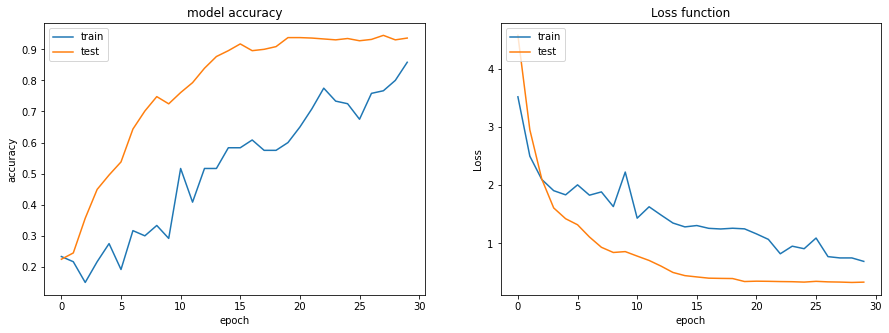

In [124]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
f.set_figheight(5)
f.set_figwidth(15)

ax1.plot(rnnGRUModel_hist.history['val_categorical_accuracy'])
ax1.plot(rnnGRUModel_hist.history['categorical_accuracy'])
ax1.title.set_text('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(rnnGRUModel_hist.history['val_loss'])
ax2.plot(rnnGRUModel_hist.history['loss'])
ax2.title.set_text('Loss function')
ax2.set_ylabel('Loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()



In [135]:
#Conv3D Model

from tensorflow.keras import regularizers

def Conv3DModel(batch_size):
        Conv3DModel = Sequential()
      
        Conv3DModel.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))
        Conv3DModel.add(BatchNormalization())
        
        Conv3DModel.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
        Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))
        Conv3DModel.add(BatchNormalization())
        
        Conv3DModel.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
        Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))
        Conv3DModel.add(BatchNormalization())
        
        
        Conv3DModel.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
        Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        Conv3DModel.add(BatchNormalization())
        
        Conv3DModel.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))        
        Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        Conv3DModel.add(BatchNormalization())
        
        Conv3DModel.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
        Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        Conv3DModel.add(BatchNormalization())
        
       
        Conv3DModel.add(Dropout(0.25))
        Conv3DModel.add(Flatten())
        
        Conv3DModel.add(Dense(256,activation='relu'))
        Conv3DModel.add(Dropout(0.5))
        
        Conv3DModel.add(Dense(128,activation='relu'))
        Conv3DModel.add(Dropout(0.5))
        
        Conv3DModel.add(Dense(64,activation='relu'))
        Conv3DModel.add(Dropout(0.5))
        
        Conv3DModel.add(Dense(5, activation='softmax'))
        
        return Conv3DModel

In [136]:
Conv3DModel = Conv3DModel(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

Conv3DModel.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (Conv3DModel.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 10, 100, 100, 8)   656       
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 5, 50, 50, 8)      0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 5, 50, 50, 8)      32        
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 5, 50, 50, 16)     3472      
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 2, 25, 25, 16)     0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 2, 25, 25, 16)     64        
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 2, 25, 25, 32)   

In [140]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'
reduceLRConv3D = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2,verbose = 1, mode = "auto", cooldown = 0)
checkpointConv3D = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=num_epochs)

#LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [reduceLRConv3D,checkpointConv3D]

In [141]:
conv3d_model_history = Conv3DModel.fit_generator(train_generator,  steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                                           callbacks=callbacks_list,  validation_data=val_generator, validation_steps=validation_steps, class_weight=None,
                                           workers=1, initial_epoch=0)

Epoch 1/30
23/23 [==============================] - 54s 2s/step - loss: 2.5006 - categorical_accuracy: 0.2739 - val_loss: 2.5128 - val_categorical_accuracy: 0.2083
Epoch 2/30
 6/23 [======>.......................] - ETA: 30s - loss: 2.4182 - categorical_accuracy: 0.2944
Epoch 00002: saving model to model_init_2021-06-2016_03_42.681726/model_3d-00002-2.41137-0.29048.h5
23/23 [==============================] - 54s 2s/step - loss: 2.3591 - categorical_accuracy: 0.3101 - val_loss: 2.5669 - val_categorical_accuracy: 0.2000
Epoch 3/30
13/23 [===============>..............] - ETA: 20s - loss: 2.2685 - categorical_accuracy: 0.3615
Epoch 00003: saving model to model_init_2021-06-2016_03_42.681726/model_3d-00003-2.27138-0.35714.h5
23/23 [==============================] - ETA: 0s - loss: 2.2214 - categorical_accuracy: 0.3623
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
23/23 [==============================] - 60s 3s/step - loss: 2.2214 - categorical_accuracy: 0